# Z by HP Audio Classifier project

## Import the required libraries :
1) Tensorflow : For model creation and training
2) TFIO : Audio file processing
3) Matplotlib : Plot graphs and Spectograms

In [4]:
import os
import tensorflow as tf
import tensorflow_io as tfio
import matplotlib.pyplot as plt

## Load the Capuchin and Non Capuchin bird's audio data separately 

In [5]:
capu_file=os.path.join('data','Parsed_Capuchinbird_Clips','XC3776-0.wav')
non_capu_file=os.path.join('data','Parsed_Not_Capuchinbird_Clips','afternoon-birds-song-in-forest-0.wav')

# Function 1 : 

## Converts the Audio file into 16000Hz frequency with a single channel
1) Read the file contents as Binary data.
2) Converts binary data into 2 forms,
       WAV - Tensor containing audio waveform as a floating point representation.
       Sample rate - Sample rate of the audio file.
   converts the audio file from stereo to mono (single) channel
3) Squeezes the tensor of dimension [samples,1] to [samples] by removing the last axis.
4) Converts the sample rate to 64-bit integer.
5) Resample the audio (tenser) from 44100 to 16000Hz sample rate as ML models expect audio inputs at specific sample rates.
6) Returns the tensor (WAV).

#### NOTE :
As each audio clip is 3 seconds long, and initial size of WAV before sampling is 132300, the sample rate is 44100 which is 132300/3. After resampling it to 16000, the duration of audio clip reamins 3 seconds and thus the new size of WAV becomes 16000*3=48000.

In [6]:
def wav_16k_mono(file):
    file_cont = tf.io.read_file(file)
    wav, sample_rate = tf.audio.decode_wav(file_cont,desired_channels=1)

    wav=tf.squeeze(wav,axis=-1)
    sample_rate=tf.cast(sample_rate,dtype=tf.int64)

    wav=tfio.audio.resample(wav,rate_in=sample_rate, rate_out=16000)
    return wav

In [7]:
wave = wav_16k_mono(capu_file)
nwave = wav_16k_mono(non_capu_file)

2025-01-26 00:20:17.534164: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX AVX2 FMA


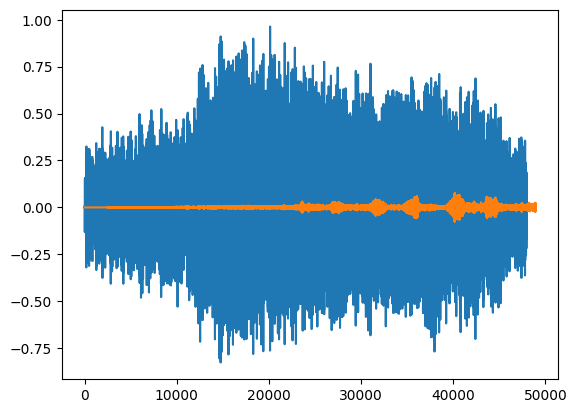

In [8]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

## Get all the Capuchin bird audios (Positives) and Non Capuchin bird audios (Negatives)

In [9]:
POS = os.path.join('data','Parsed_Capuchinbird_Clips')
NEG = os.path.join('data','Parsed_Not_Capuchinbird_Clips')

In [10]:
pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')

In [11]:
pos.as_numpy_iterator().next()

b'data/Parsed_Capuchinbird_Clips/XC520626-0.wav'

## Creating single data for all clips by adding labels :

1) Labels each positive data set as 1 and negative dataset as 0.
2) Zips together the examples and their corresponding labels. Eg, [Positive,1], [Negative,0].
3) Concatenates the positive and negative data into one with their corresponding labels. Firstly, all the positives followed by the negatives. 

In [12]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

### Calculates the length of audio samples and adds them to a list.

#### NOTE : 
As the sampling rate is 16000, the length of each sample will be calculated by (Duration of clip)*16000. Also the avg length of sample is 54,156.

In [13]:
lengths=[]
for file in os.listdir(os.path.join('data','Parsed_Capuchinbird_Clips')):
    tensor_wave=wav_16k_mono(os.path.join('data','Parsed_Capuchinbird_Clips',file))
    lengths.append(len(tensor_wave))

In [ ]:
lengths

In [ ]:
tf.math.reduce_mean(lengths)

# Function 2 : Preprocessing the audio file into a Spectogram 

1) Resamples the file to 16000 sample rate.
2) Trims the audio to first 48000 samples, which corresponds to the first 3 seconds of the clip.
3) Creates a tensor of zeros to pad the audio which have less than 48000 samples. All the clips cant have 48000 samples. Some might have more than 48000 some might have less, making the avg sample rate 54156.
4) Pads the audios with zeros at the beginning having less than 48000 samples to make the final length as 48000.
5) Short-time Fourier transform (STFT) -
   
       1. Converts the time-domain signal to time-frequency signal.
       2. Splits the audio into overlapping frames of size 480 which is 30ms corresponding to 16000.
       3. Shifts frames by step size 48 which is 3ms.
       4. Op complex value tensor representing frequency over time.
   
6) Converts negative values to positive values.
7) Expands dimension by adding channel at axis 2. This makes spectogram compatible with ML model requiring input in the form (height,width,channel).

In [14]:
def preprocess(file_path, label): 
    wav = wav_16k_mono(file_path)
    wav = wav[:48000]
    
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    
    return spectrogram, label

In [15]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [16]:
spectogram, label = preprocess(filepath, label)

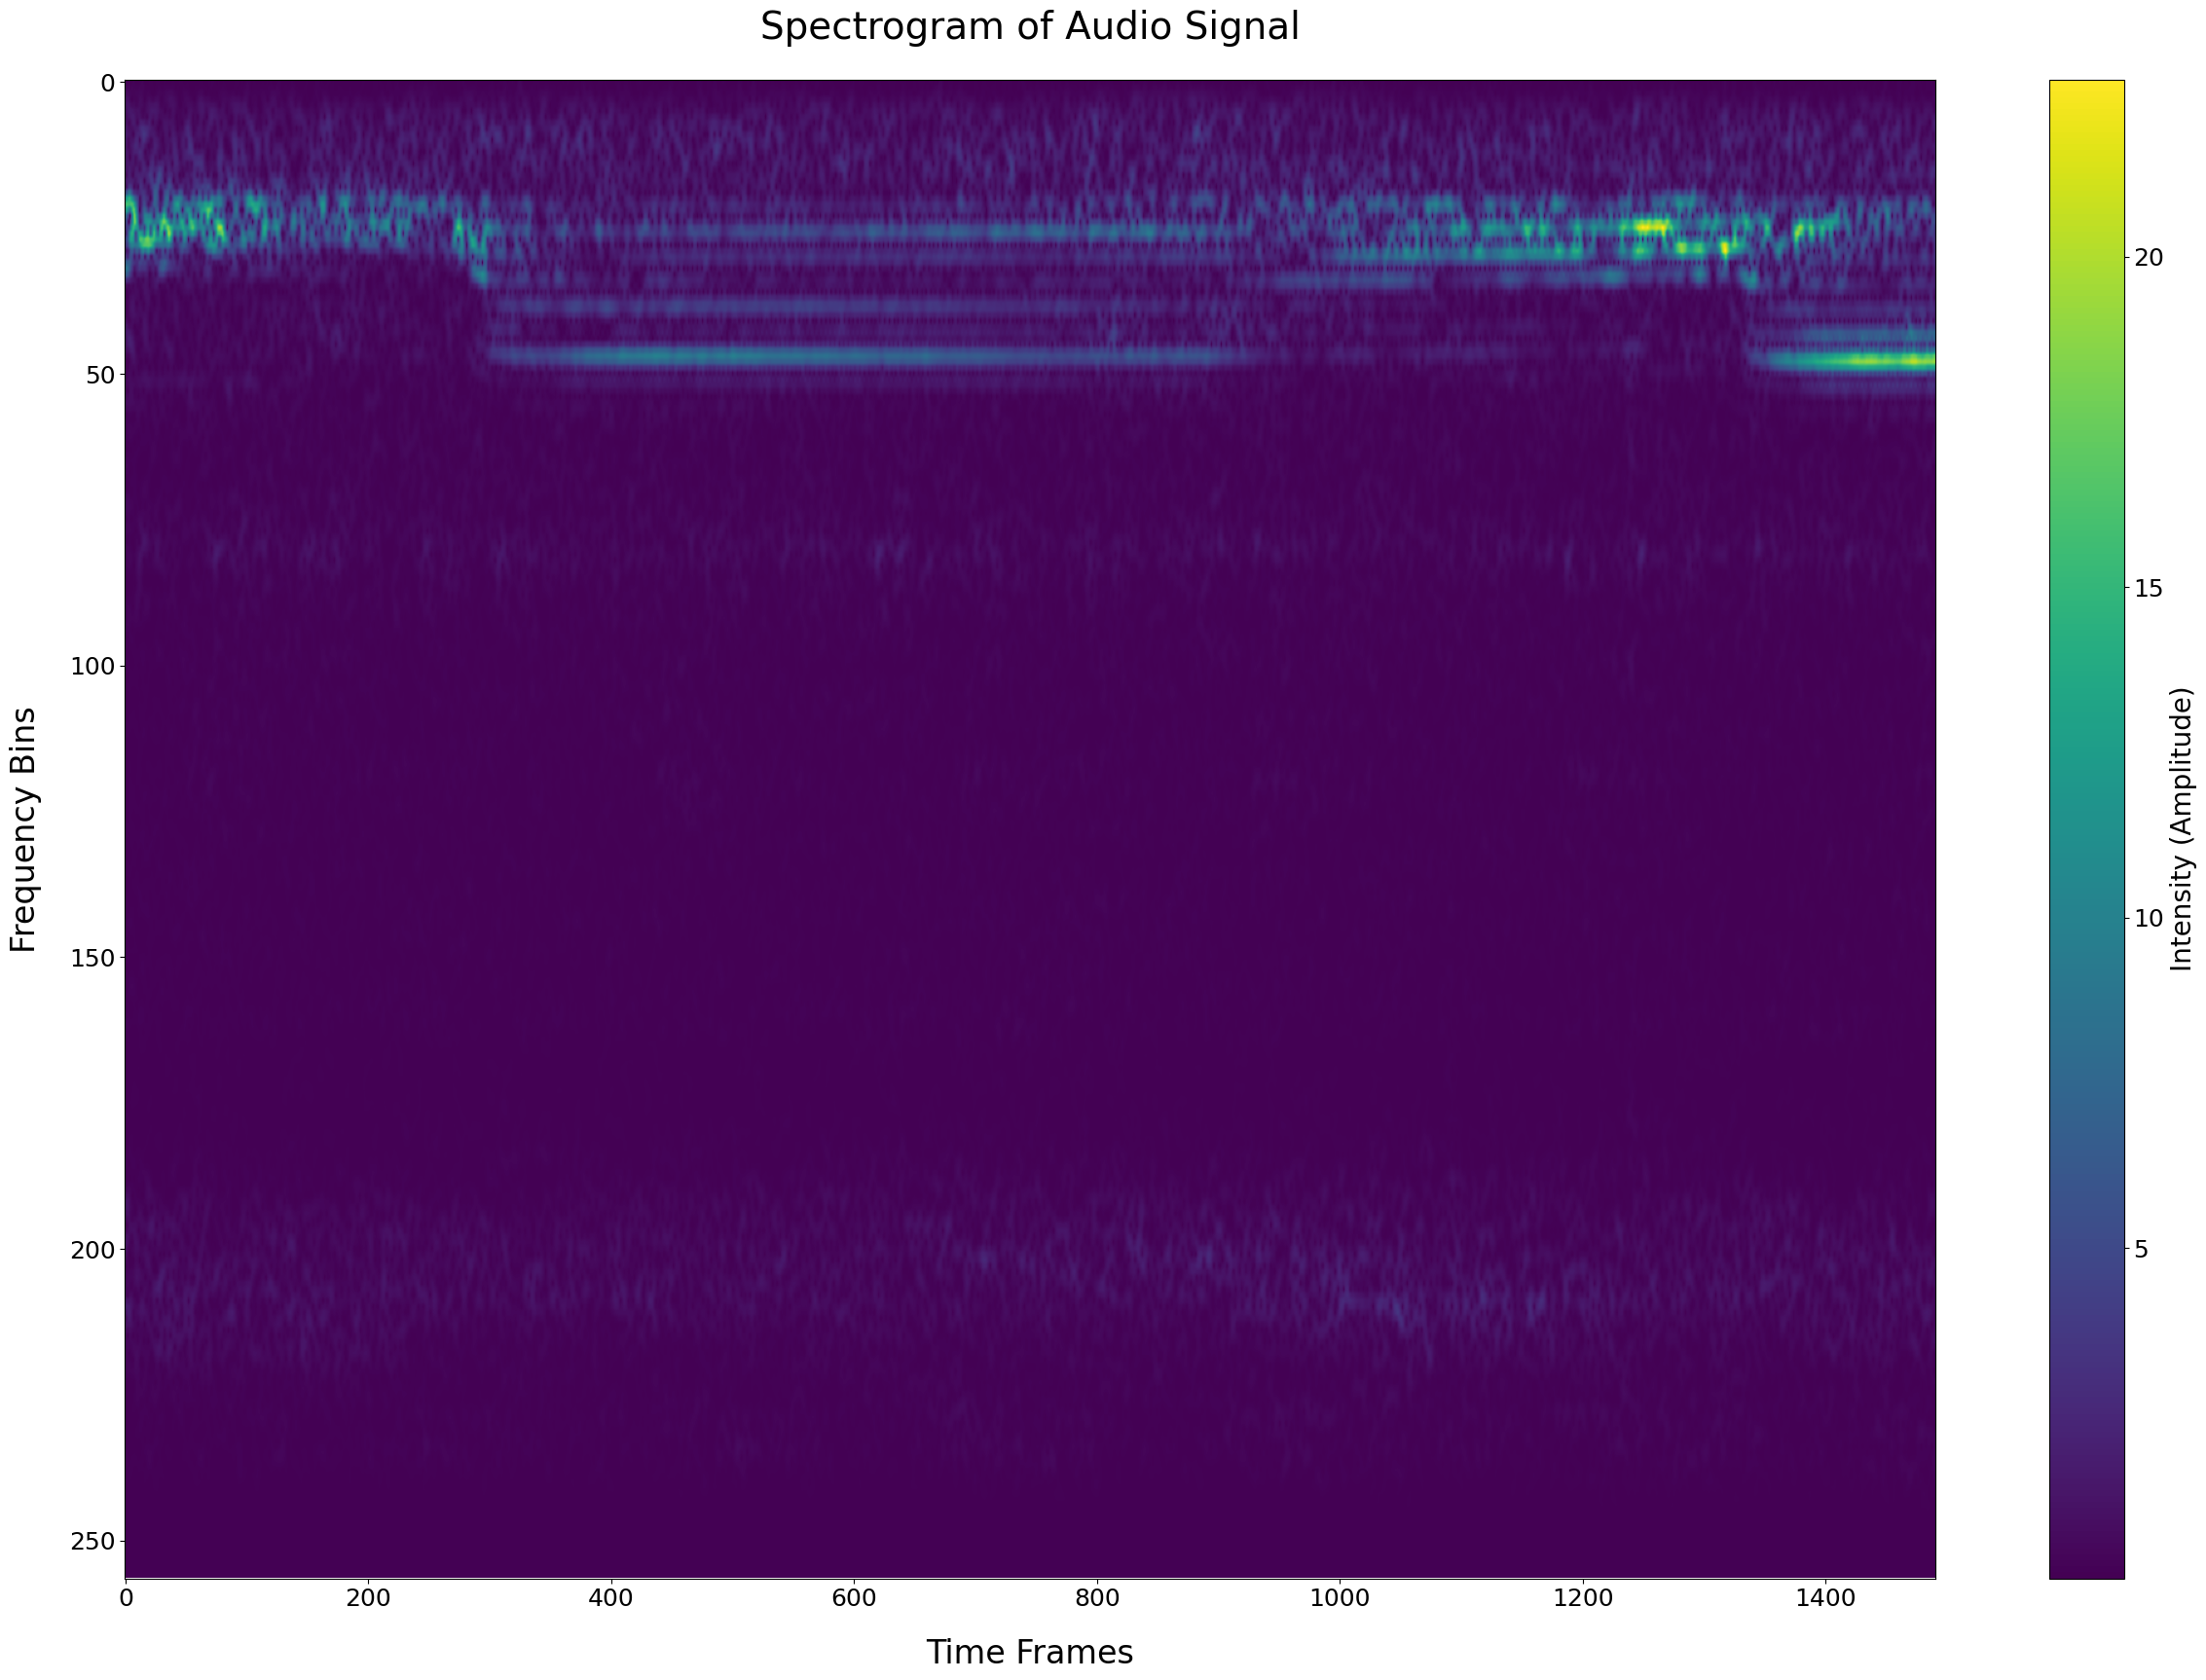

In [17]:
plt.figure(figsize=(30, 20))

spectrogram_data = tf.transpose(spectogram)[0]
plt.imshow(spectrogram_data, aspect='auto', cmap='viridis')

plt.xlabel('Time Frames', fontsize=24, labelpad=20)
plt.ylabel('Frequency Bins', fontsize=24, labelpad=20)

plt.title('Spectrogram of Audio Signal', fontsize=28, pad=30)

cbar = plt.colorbar()
cbar.set_label('Intensity (Amplitude)', fontsize=20)
cbar.ax.tick_params(labelsize=18)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.show()


In [ ]:
len(data)

## Using tensorflow's data API for data processing :

1) Map - Applies the preprocesses function to each tuple in the data.
2) Cache - Caches the processed data to avoid reloading the data in future.
3) Shuffle - Shuufles the dataset with buffer size 256. Buffer size provides the size to specify how many elements to sample randomly to shuffle the data.
4) Batch - Groups the data into batch size of 16 each.
5) Prefetch - Prepares the next batch for training. 8 next batches are prepared for training.  

In [18]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=256)
data = data.batch(16)
data.prefetch(8)

<_PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [19]:
len(data)

51

In [20]:
train = data.take(39)
test = data.skip(39).take(12)

In [21]:
samples, label = train.as_numpy_iterator().next()

2025-01-26 00:20:46.895253: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [22]:
samples.shape

(16, 1491, 257, 1)

In [23]:
label.shape

(16,)

# CNN model creation :

In [24]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(1491, 257, 1)),  # Input shape example
    MaxPooling2D((2, 2)),  # Downsampling
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),  # Further downsampling
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # For binary classification
])

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 1489, 255, 16)     160       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 744, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 742, 125, 16)      2320      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 371, 62, 16)       0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 368032)            0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [26]:
from tensorflow.keras.optimizers import Adam

model.compile('Adam',loss='binary_crossentropy',metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [27]:
hist = model.fit(train, epochs=5, validation_data=test)

Epoch 1/5
39/39 [==============================] - 13s 313ms/step - loss: 0.8187 - accuracy: 0.9103 - recall: 0.8515 - precision: 0.8687 - val_loss: 0.0705 - val_accuracy: 0.9785 - val_recall: 0.8696 - val_precision: 0.9524
Epoch 2/5
39/39 [==============================] - 11s 293ms/step - loss: 0.0648 - accuracy: 0.9776 - recall: 0.9447 - precision: 0.9843 - val_loss: 0.0185 - val_accuracy: 1.0000 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 3/5
39/39 [==============================] - 12s 297ms/step - loss: 0.0146 - accuracy: 0.9984 - recall: 0.9950 - precision: 1.0000 - val_loss: 0.0014 - val_accuracy: 1.0000 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 4/5
39/39 [==============================] - 12s 297ms/step - loss: 0.0067 - accuracy: 0.9984 - recall: 0.9947 - precision: 1.0000 - val_loss: 0.0057 - val_accuracy: 1.0000 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 5/5
39/39 [==============================] - 12s 300ms/step - loss: 0.0025 - accuracy: 1.0000 - re

# Plot graphs to demonstrate loss, accuracy, precsion, recall :

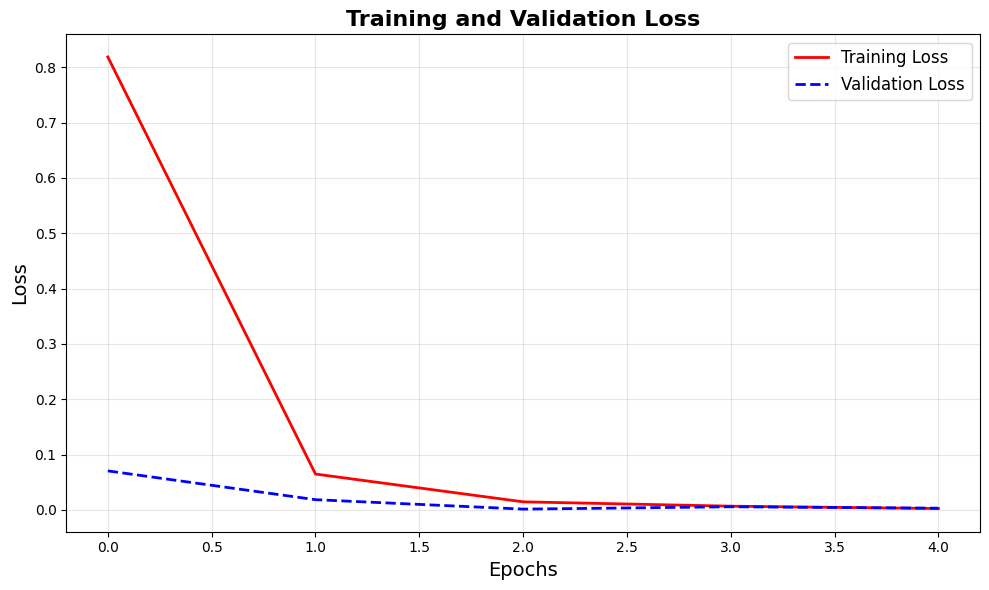

In [66]:
plt.figure(figsize=(10, 6))
plt.plot(hist.history['loss'], color='red', label='Training Loss', linewidth=2)
plt.plot(hist.history['val_loss'], color='blue', label='Validation Loss', linewidth=2, linestyle='--')
plt.title('Training and Validation Loss', fontsize=16, fontweight='bold')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


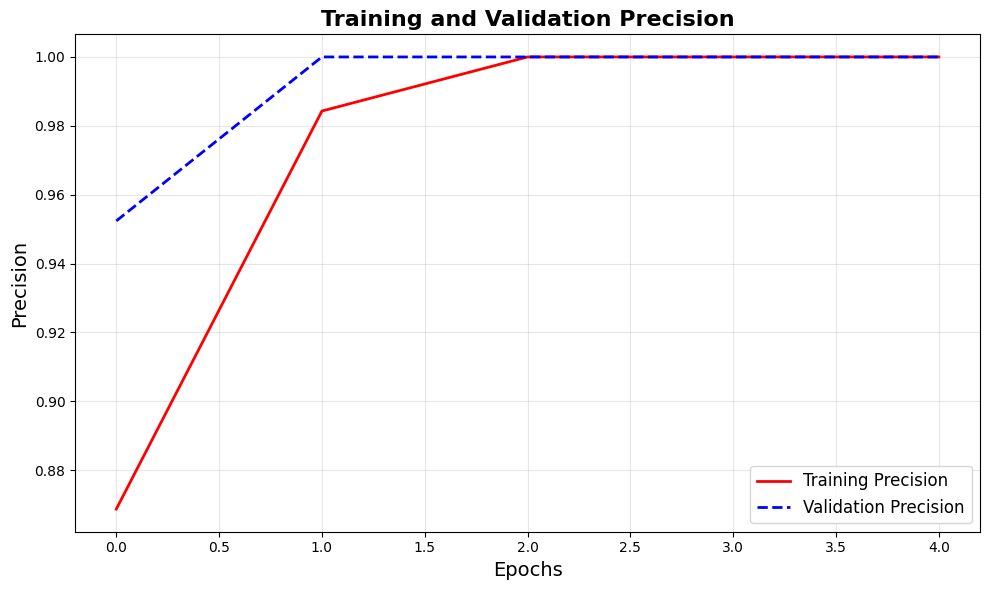

In [67]:
plt.figure(figsize=(10, 6))
plt.plot(hist.history['precision'], color='red', label='Training Precision', linewidth=2)
plt.plot(hist.history['val_precision'], color='blue', label='Validation Precision', linewidth=2, linestyle='--')
plt.title('Training and Validation Precision', fontsize=16, fontweight='bold')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


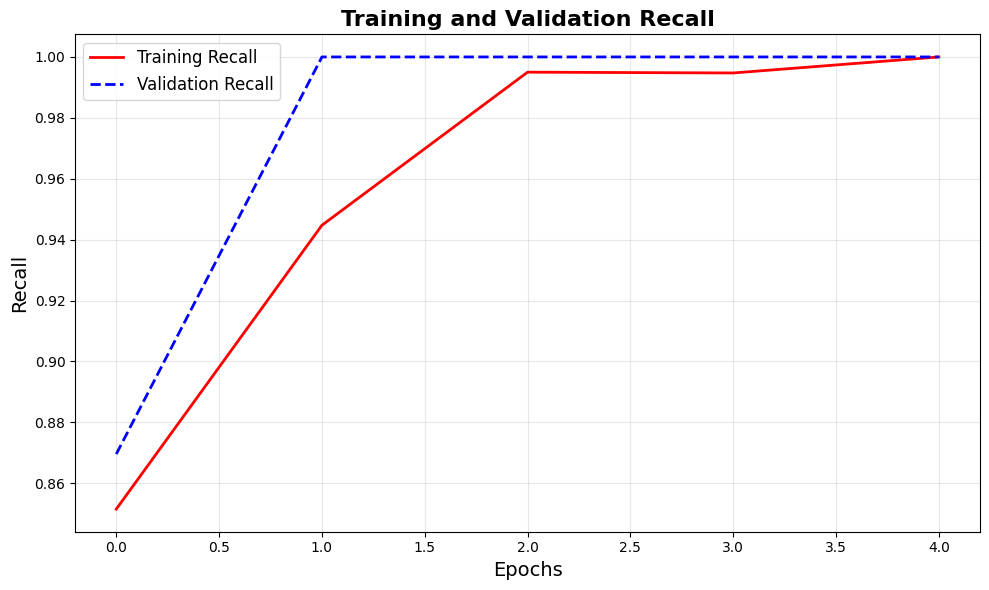

In [68]:
plt.figure(figsize=(10, 6))
plt.plot(hist.history['recall'], color='red', label='Training Recall', linewidth=2)
plt.plot(hist.history['val_recall'], color='blue', label='Validation Recall', linewidth=2, linestyle='--')
plt.title('Training and Validation Recall', fontsize=16, fontweight='bold')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Recall', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


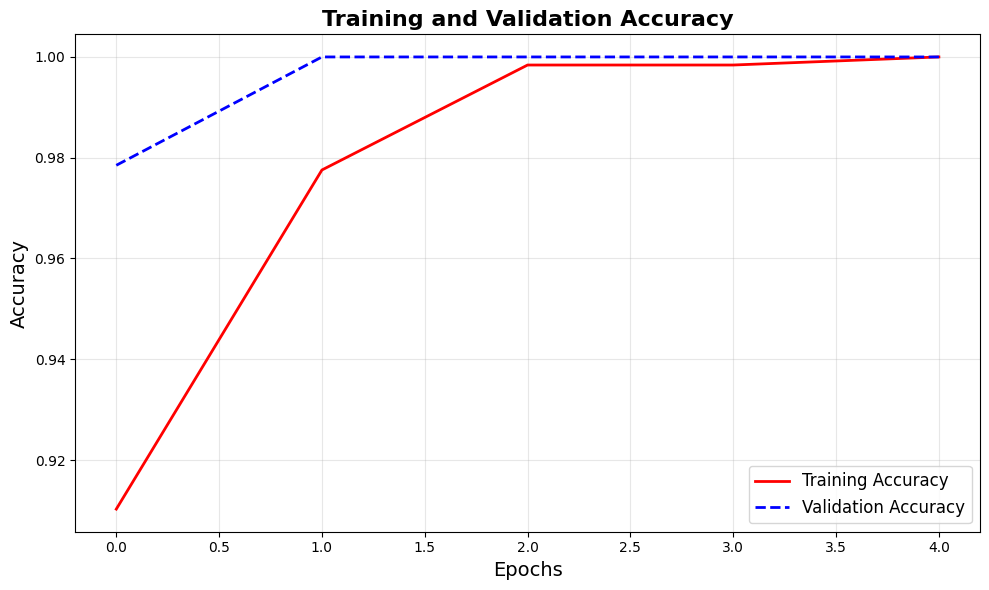

In [69]:
plt.figure(figsize=(10, 6))
plt.plot(hist.history['accuracy'], color='red', label='Training Accuracy', linewidth=2)
plt.plot(hist.history['val_accuracy'], color='blue', label='Validation Accuracy', linewidth=2, linestyle='--')
plt.title('Training and Validation Accuracy', fontsize=16, fontweight='bold')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# Prediction on the test dataset

In [32]:
x_test, y_test = test.as_numpy_iterator().next()

In [33]:
x_test.shape

(16, 1491, 257, 1)

In [34]:
y_test.shape

(16,)

In [35]:
yhat=model.predict(x_test)

1/1 [==============================] - 0s 93ms/step


In [36]:
yhat

array([[5.7870511e-15],
       [2.0263635e-09],
       [1.0000000e+00],
       [1.7486863e-07],
       [1.4348491e-14],
       [3.3567485e-13],
       [3.0614595e-13],
       [2.5957227e-15],
       [1.2365273e-03],
       [1.8233679e-05],
       [2.9984652e-05],
       [1.0000000e+00],
       [1.0710643e-06],
       [1.0000000e+00],
       [3.7483962e-06],
       [2.6948424e-06]], dtype=float32)

In [37]:
yhat = [1 if pred > 0.5 else 0 for pred in yhat]

In [38]:
yhat

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]

In [39]:
tf.math.reduce_sum(yhat)

<tf.Tensor: shape=(), dtype=int32, numpy=3>

In [40]:
tf.math.reduce_sum(y_test)

<tf.Tensor: shape=(), dtype=float32, numpy=3.0>

# Resampling a MP3 file to 16000 sample rate :

1) Load the audio file in tensor format. tensor format may be [samples,channels (2 for stereo)]
2) For stereo files having 2 channels, we calculate the sum of both left and right channel and convert it to a single channel.
3) Sampling rate of initial audio is extracted and resampled to 16000 sample rate.

In [41]:
def load_mp3_16k_mono(file):
    res = tfio.audio.AudioIOTensor(file)

    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1)/2

    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)

    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)

    return wav

In [42]:
mp3_file = os.path.join('data','Forest Recordings','recording_00.mp3')

In [43]:
wav = load_mp3_16k_mono(mp3_file)

# Audio Slices :

1) wav - Input data
2) wav - Target data (Same as input)
3) seq length - Length of each sequence, 48000 that is 3s each.
4) seq stride - How much the starting point of each seq shifts, 48000 that is 3s. After each 3sec, the starting point shifts by 3sec.
5) batch size - No. of seq to return per batch.

In [44]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [45]:
samples, index = audio_slices.as_numpy_iterator().next()

In [46]:
samples.shape

(1, 48000)

In [47]:
index.shape

(1,)

In [48]:
audio_slices

<_BatchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

# Preprocessing function for MP3 files :

Similar to that of WAV file

In [49]:
def preprocess_mp3(sample, index):
    
    sample = sample[0]
    
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    
    return spectrogram

In [50]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [51]:
yhat = model.predict(audio_slices)
yhat = [1 if pred > 0.9 else 0 for pred in yhat]

1/1 [==============================] - 0s 368ms/step


In [53]:
tf.math.reduce_sum(yhat)

<tf.Tensor: shape=(), dtype=int32, numpy=5>

In [54]:
from itertools import groupby

In [55]:
calls = tf.math.reduce_sum(yhat).numpy()

In [56]:
yhat = [key for key,group in groupby(yhat)]

In [57]:
yhat

[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]

In [58]:
tf.math.reduce_sum(yhat)

<tf.Tensor: shape=(), dtype=int32, numpy=5>

In [59]:
res = {}

for file in os.listdir(os.path.join('data','Forest Recordings')):
    file_path = os.path.join('data','Forest Recordings',file)

    wav = load_mp3_16k_mono(file_path)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)

    yhat = model.predict(audio_slices)

    res[file]=yhat

1/1 [==============================] - 0s 355ms/step


In [60]:
class_preds = {}

for file, preds in res.items():
    class_preds[file] = [1 if pred > 0.99 else 0 for pred in preds]


In [61]:
class_preds

{'recording_00.mp3': [0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_01.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_02.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_03.mp3': [0,
  0,
  0,
  

In [62]:
processed = {}

for file, preds in class_preds.items():
    processed[file] = tf.math.reduce_sum([key for key, group in groupby(preds)]).numpy()


In [63]:
processed

{'recording_00.mp3': 5,
 'recording_01.mp3': 0,
 'recording_02.mp3': 0,
 'recording_03.mp3': 0,
 'recording_04.mp3': 4,
 'recording_05.mp3': 0,
 'recording_06.mp3': 5,
 'recording_07.mp3': 2,
 'recording_08.mp3': 25,
 'recording_09.mp3': 0,
 'recording_10.mp3': 5,
 'recording_11.mp3': 3,
 'recording_12.mp3': 0,
 'recording_13.mp3': 0,
 'recording_14.mp3': 0,
 'recording_15.mp3': 1,
 'recording_16.mp3': 4,
 'recording_17.mp3': 3,
 'recording_18.mp3': 1,
 'recording_19.mp3': 0,
 'recording_20.mp3': 0,
 'recording_21.mp3': 1,
 'recording_22.mp3': 2,
 'recording_23.mp3': 5,
 'recording_24.mp3': 0,
 'recording_25.mp3': 14,
 'recording_26.mp3': 2,
 'recording_27.mp3': 0,
 'recording_28.mp3': 17,
 'recording_29.mp3': 0,
 'recording_30.mp3': 1,
 'recording_31.mp3': 1,
 'recording_32.mp3': 2,
 'recording_33.mp3': 0,
 'recording_34.mp3': 4,
 'recording_35.mp3': 0,
 'recording_36.mp3': 0,
 'recording_37.mp3': 3,
 'recording_38.mp3': 1,
 'recording_39.mp3': 7,
 'recording_40.mp3': 1,
 'recording_4

# Export results to csv

In [64]:
import csv

In [65]:
with open('capuchin_audio_results.csv','w',newline='') as f:
    writer = csv.writer(f,delimiter=',')
    writer.writerow(['Recordings','Capuchin_Calls'])
    for key,value in processed.items():
        writer.writerow([key,value])